In [1]:
import numpy as np
import multiprocessing as mp
from scipy.stats import norm, normaltest, kstest, ttest_1samp
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from jobs import simulate_job
from config_plt import config_plt, get_fig_ax, save_my_fig

In [2]:
mp.set_start_method("spawn", force=True)
T = 100_000
n_reps = 10_000
a_target = 100
n_jobs = 14
args = [(seed, T, a_target) for seed in range(n_reps)]
with mp.Pool(processes=n_jobs) as pool:
    results = list(tqdm(pool.imap_unordered(simulate_job, args, chunksize=1), total=n_reps))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.65it/s]


In [3]:
psis = np.asarray([r["psi"] for r in results])
psis_naive = np.asarray([r["psi_naive"] for r in results])
tauhats = np.asarray([r["tauhat"] for r in results])
taus = np.asarray([r["tau"] for r in results])
equal_groups = np.asarray([r["equal_group"] for r in results])
t_targets = np.asarray([r["t_target"] for r in results])
ws = tauhats - taus
zs = ws / np.sqrt(psis / T)
zs_naive = ws / np.sqrt(psis_naive / T)

In [4]:
psis_equal = psis[equal_groups]
psis_equal_mean = np.mean(psis_equal)
print(psis_equal_mean)
psis_naive_equal = psis_naive[equal_groups]
psis_naive_equal_mean = np.mean(psis_naive_equal)
print(psis_naive_equal_mean)

psis_unequal = psis[~equal_groups]
psis_unequal_mean = np.mean(psis_unequal)
print(psis_unequal_mean)
psis_naive_unequal = psis_naive[~equal_groups]
psis_naive_unequal_mean = np.mean(psis_naive_unequal)
print(psis_naive_unequal_mean)

32.49942027075987
32.50038064321741
245.3933269101182
168.21702768259095


In [5]:
def adaptive_kstest(x):
    return kstest(x, lambda y: norm.cdf(y, scale=np.std(x)))

TtestResult(statistic=np.float64(-0.5076203810092127), pvalue=np.float64(0.6117307908727372), df=np.int64(9999))
TtestResult(statistic=np.float64(-0.21876035135016944), pvalue=np.float64(0.8268411985471891), df=np.int64(9999))
NormaltestResult(statistic=np.float64(3.316714273823586), pvalue=np.float64(0.19045160914660236))
KstestResult(statistic=np.float64(0.009419576561521703), pvalue=np.float64(0.33538053682671165), statistic_location=np.float64(0.0728442706115857), statistic_sign=np.int8(1))
./figures/z


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


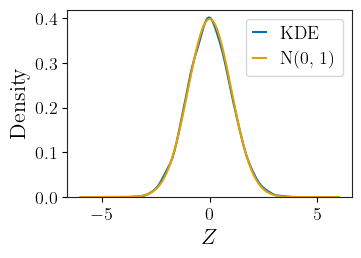

In [6]:
print(ttest_1samp(zs, popmean=0.))
print(ttest_1samp(zs**2, popmean=1.))
print(normaltest(zs))
print(adaptive_kstest(zs))
fig, ax = get_fig_ax()
ax = sns.kdeplot(zs, ax=ax, bw_method=0.2, label="KDE")
zs_vals = np.linspace(-6, 6, 1000)
gaussian_pdf_vals = norm.pdf(zs_vals)
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("$Z$")
ax.set_ylim(0, 0.42)
ax.legend(handlelength=0.7)
save_my_fig(fig, "z")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


TtestResult(statistic=np.float64(-0.6353709036001005), pvalue=np.float64(0.5252010797976139), df=np.int64(9999))
TtestResult(statistic=np.float64(12.779312963009458), pvalue=np.float64(4.171635976319819e-37), df=np.int64(9999))
NormaltestResult(statistic=np.float64(6.843979811145914), pvalue=np.float64(0.032647405005601496))
KstestResult(statistic=np.float64(0.009798578323404472), pvalue=np.float64(0.29033573149030767), statistic_location=np.float64(0.2833188101931635), statistic_sign=np.int8(1))
./figures/z-naive


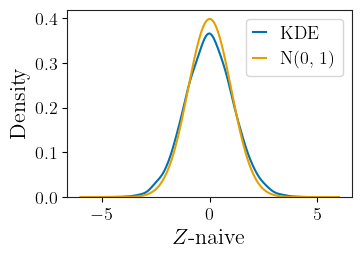

In [7]:
print(ttest_1samp(zs_naive, popmean=0.))
print(ttest_1samp(zs_naive**2, popmean=1.))
print(normaltest(zs_naive))
print(adaptive_kstest(zs_naive))
fig, ax = get_fig_ax()
ax = sns.kdeplot(zs_naive, ax=ax, bw_method=0.2, label="KDE")
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("$Z$-naive")
ax.set_ylim(0, 0.42)
ax.legend(handlelength=0.7)
save_my_fig(fig, "z-naive")

TtestResult(statistic=np.float64(-1.154201760877776), pvalue=np.float64(0.24844504605111958), df=np.int64(9999))
NormaltestResult(statistic=np.float64(384.74307130943845), pvalue=np.float64(2.8451396622085222e-84))
KstestResult(statistic=np.float64(0.06355864444043391), pvalue=np.float64(1.4568638880252603e-35), statistic_location=np.float64(0.02168206121505034), statistic_sign=np.int8(1))
./figures/w


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


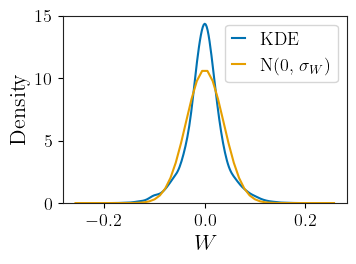

In [9]:
print(ttest_1samp(ws, popmean=0.))
print(normaltest(ws))
print(adaptive_kstest(ws))
fig, ax = get_fig_ax()
ax = sns.kdeplot(ws, bw_method=0.2, ax=ax, label="KDE")
ws_abs_max = np.max(np.abs(ws))
ws_vals = np.linspace(-ws_abs_max*1.5, ws_abs_max*1.5)
ax.plot(ws_vals, norm.pdf(ws_vals, scale=np.std(ws)), label="N(0, $\\sigma_W$)")
ax.set_xlabel("$W$")
ax.set_ylim(0, 15)
ax.legend(handlelength=0.7)
save_my_fig(fig, "w")

(array([  28.,  260., 1284., 2630., 2696., 1974.,  827.,  258.,   36.,
           7.]),
 array([151. , 161.8, 172.6, 183.4, 194.2, 205. , 215.8, 226.6, 237.4,
        248.2, 259. ]),
 <BarContainer object of 10 artists>)

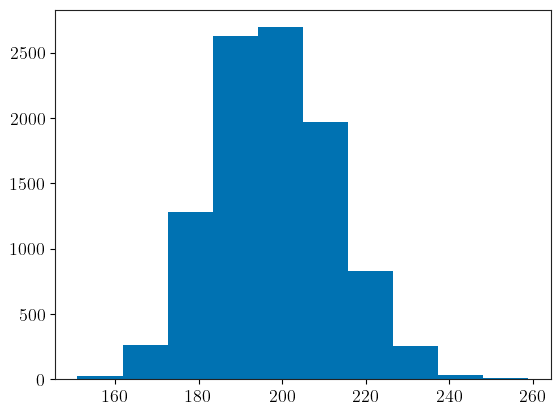

In [10]:
plt.hist(t_targets)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/tau


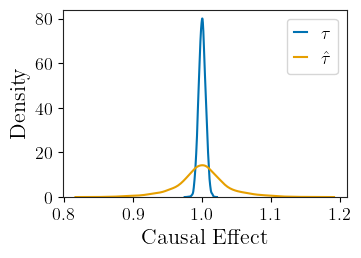

In [11]:
fig, ax = get_fig_ax()
ax = sns.kdeplot(taus, ax=ax, label="$\\tau$")
ax = sns.kdeplot(tauhats, ax=ax, label="$\\hat{\\tau}$")
ax.set_xlabel("Causal Effect")
ax.legend(handlelength=0.7)
save_my_fig(fig, "tau")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/psi


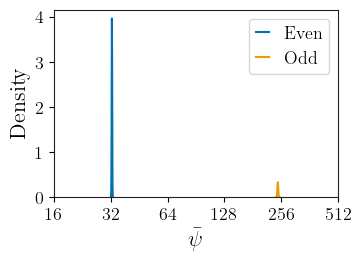

In [12]:
fig, ax = get_fig_ax()
ax = sns.kdeplot(psis_equal, bw_method=0.2, ax=ax, label="Even")
ax = sns.kdeplot(psis_unequal, bw_method=0.2, ax=ax, label="Odd")
ax.set_xlabel("$\\bar{\\psi}$")
ax.set_xscale("log", base=2)
xticks = [2**i for i in range(4, 10)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(handlelength=0.7)
save_my_fig(fig, "psi")

In [13]:
def fit_two_component_zero_mean_gmm(x, random_state=0):
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    gmm = GaussianMixture(
        n_components=2,
        covariance_type="spherical",
        n_init=10,
        init_params="random_from_data",
        random_state=random_state,
        reg_covar=1e-8,
        max_iter=1000,
        tol=1e-6,
        weights_init=np.array([0.5, 0.5]),
        means_init=np.array([(0.,), (0.,)])
    )
    gmm.fit(x)
    pi = gmm.weights_
    sigmas = np.sqrt(gmm.covariances_)
    means = gmm.means_.ravel()
    loglik = gmm.score(x) * x.size

    # Enforce ordering (sigma1 <= sigma2) for identifiability
    order = np.argsort(sigmas)
    pi = pi[order]
    sigmas = sigmas[order]
    means = means[order]

    # Print results
    print(f"pi: {pi}")
    print(f"sigmas: {sigmas}")
    print(f"sigmas^2: {sigmas**2}")
    print(f"means: {means}")

fit_two_component_zero_mean_gmm(ws * np.sqrt(T))
print(f"Avg psi_equal: {psis_equal_mean}")
print(f"Avg psi_unequal: {psis_unequal_mean}")
print(f"sqrt(Avg psi_equal): {np.sqrt(psis_equal_mean)}")
print(f"sqrt(Avg psi_unequal): {np.sqrt(psis_unequal_mean)}")

pi: [0.48327583 0.51672417]
sigmas: [ 5.55076785 15.53536407]
sigmas^2: [ 30.81102373 241.34753686]
means: [-0.05230634 -0.21501525]
Avg psi_equal: 32.49942027075987
Avg psi_unequal: 245.3933269101182
sqrt(Avg psi_equal): 5.700826279651036
sqrt(Avg psi_unequal): 15.66503517104632
